### Import ###

In [1]:
%matplotlib inline
import numpy as np
import pandas as pd
import matplotlib.pyplot as plt
import scipy.stats as stats
import sklearn.linear_model as linear_model
import seaborn as sns
#import xgboost as xgb 누락 집에가서 다운
from sklearn.model_selection import KFold
from IPython.display import HTML, display
from sklearn.manifold import TSNE
from sklearn.cluster import KMeans
from sklearn.decomposition import PCA
from sklearn.preprocessing import StandardScaler

pd.options.display.max_rows = 1000
pd.options.display.max_columns = 20

train = pd.read_csv('./train (1).csv')
test = pd.read_csv('./test (2).csv')

quantitative = [f for f in train.columns if train.dtypes[f] != 'object']
quantitative.remove('SalePrice')
quantitative.remove('Id')
qualitative = [f for f in train.columns if train.dtypes[f] == 'object']

In [2]:
train.head()

,Id,MSSubClass,MSZoning,LotFrontage,LotArea,Street,Alley,LotShape,LandContour,Utilities,...,PoolArea,PoolQC,Fence,MiscFeature,MiscVal,MoSold,YrSold,SaleType,SaleCondition,SalePrice
0,1,60,RL,65.0,8450,Pave,NaN,Reg,Lvl,AllPub,...,0,NaN,NaN,NaN,0,2,2008,WD,Normal,208500
1,2,20,RL,80.0,9600,Pave,NaN,Reg,Lvl,AllPub,...,0,NaN,NaN,NaN,0,5,2007,WD,Normal,181500
2,3,60,RL,68.0,11250,Pave,NaN,IR1,Lvl,AllPub,...,0,NaN,NaN,NaN,0,9,2008,WD,Normal,223500
3,4,70,RL,60.0,9550,Pave,NaN,IR1,Lvl,AllPub,...,0,NaN,NaN,NaN,0,2,2006,WD,Abnorml,140000
4,5,60,RL,84.0,14260,Pave,NaN,IR1,Lvl,AllPub,...,0,NaN,NaN,NaN,0,12,2008,WD,Normal,250000


In [3]:
test.head()
#자료의 구조가 train과 test 둘다 같다는 것을 알 수 있다

,Id,MSSubClass,MSZoning,LotFrontage,LotArea,Street,Alley,LotShape,LandContour,Utilities,...,ScreenPorch,PoolArea,PoolQC,Fence,MiscFeature,MiscVal,MoSold,YrSold,SaleType,SaleCondition
0,1461,20,RH,80.0,11622,Pave,NaN,Reg,Lvl,AllPub,...,120,0,NaN,MnPrv,NaN,0,6,2010,WD,Normal
1,1462,20,RL,81.0,14267,Pave,NaN,IR1,Lvl,AllPub,...,0,0,NaN,NaN,Gar2,12500,6,2010,WD,Normal
2,1463,60,RL,74.0,13830,Pave,NaN,IR1,Lvl,AllPub,...,0,0,NaN,MnPrv,NaN,0,3,2010,WD,Normal
3,1464,60,RL,78.0,9978,Pave,NaN,IR1,Lvl,AllPub,...,0,0,NaN,NaN,NaN,0,6,2010,WD,Normal
4,1465,120,RL,43.0,5005,Pave,NaN,IR1,HLS,AllPub,...,144,0,NaN,NaN,NaN,0,1,2010,WD,Normal


In [4]:
train.isnull().sum() #결측치들 확인

Id                  0
MSSubClass          0
MSZoning            0
LotFrontage       259
LotArea             0
Street              0
Alley            1369
LotShape            0
LandContour         0
Utilities           0
LotConfig           0
LandSlope           0
Neighborhood        0
Condition1          0
Condition2          0
BldgType            0
HouseStyle          0
OverallQual         0
OverallCond         0
YearBuilt           0
YearRemodAdd        0
RoofStyle           0
RoofMatl            0
Exterior1st         0
Exterior2nd         0
MasVnrType          8
MasVnrArea          8
ExterQual           0
ExterCond           0
Foundation          0
BsmtQual           37
BsmtCond           37
BsmtExposure       38
BsmtFinType1       37
BsmtFinSF1          0
BsmtFinType2       38
BsmtFinSF2          0
BsmtUnfSF           0
TotalBsmtSF         0
Heating             0
HeatingQC           0
CentralAir          0
Electrical          1
1stFlrSF            0
2ndFlrSF            0
LowQualFin

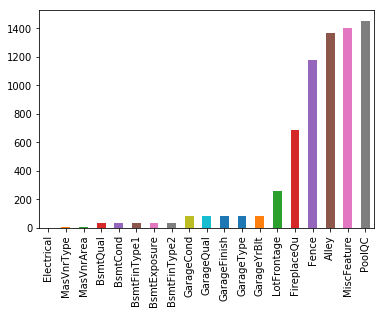

In [5]:
missing = train.isnull().sum()
missing = missing[missing > 0] #0보다 큰값들 즉 결측치를 제외한 값들을 missing이라는 변수에 대입
missing.sort_values(inplace = True) #변수들 정렬
missing.plot.bar() # bar그래프로 표시


/anaconda3/lib/python3.7/site-packages/scipy/stats/stats.py:1713: FutureWarning: Using a non-tuple sequence for multidimensional indexing is deprecated; use `arr[tuple(seq)]` instead of `arr[seq]`. In the future this will be interpreted as an array index, `arr[np.array(seq)]`, which will result either in an error or a different result.
  return np.add.reduce(sorted[indexer] * weights, axis=axis) / sumval


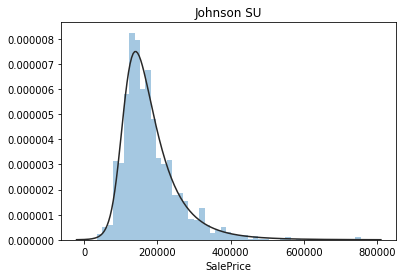

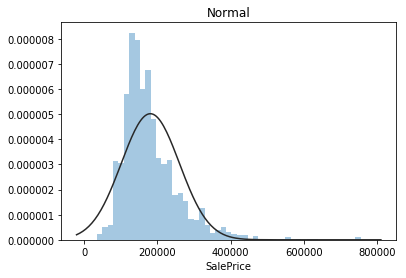

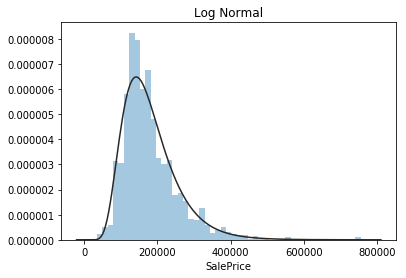

In [6]:
import scipy.stats as st
y= train['SalePrice']
plt.figure(1) ; plt.title('Johnson SU')
sns.distplot(y, kde=False, fit=st.johnsonsu)
plt.figure(2); plt.title('Normal') #정규분포
sns.distplot(y, kde=False, fit=st.norm)
plt.figure(3) ; plt.title("Log Normal")
sns.distplot(y, kde=False, fit=st.lognorm)
#그래프별 비교를 해봤을때 정규분포를 따르지 않는다는것을 알 수 있다 
#회귀를 수행하기 전에 변환을 해야하며 로그 변환은 Johnson분포에 적절하다

In [7]:
test_normality = lambda x : stats.shapiro(x.fillna(0))[1] < 0.01 #?
normal = pd.DataFrame(train[quantitative]) #train안에 quan을 normal로 지정
normal = normal.apply(test_normality)
print(not normal.any())
#정규분포가 아니므로 변환해야함

False


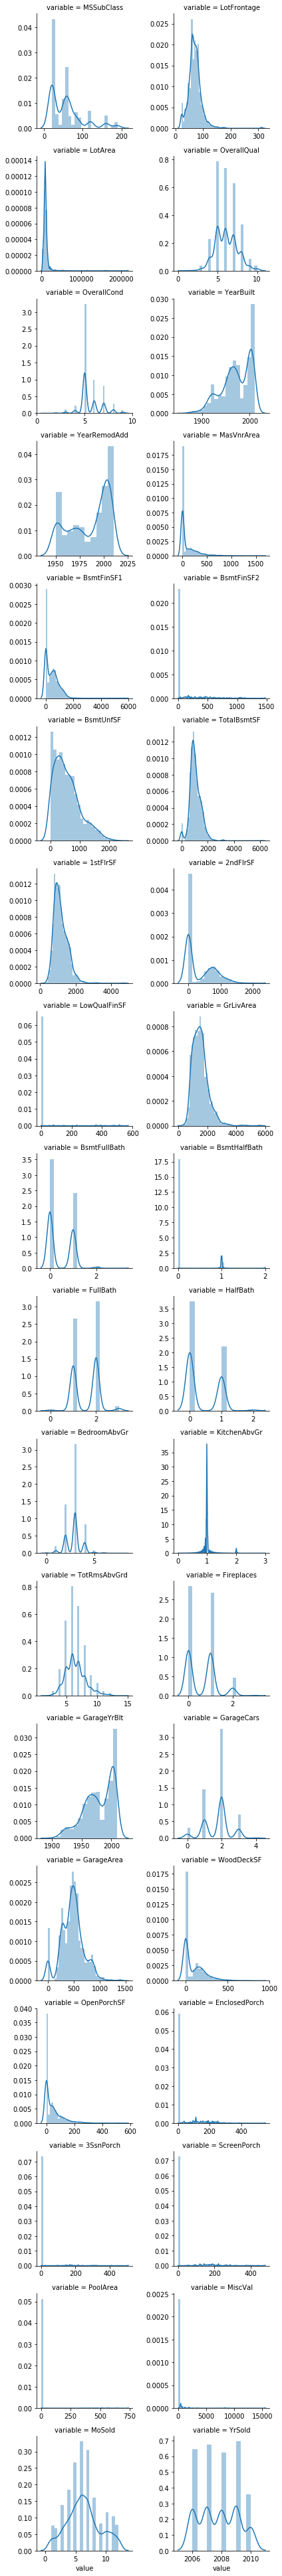

In [8]:
f = pd.melt(train, value_vars=quantitative)
#.melt는 데이터전처리하는것으로 variable에 칼럼들을 넣어주는것
g = sns.FacetGrid(f, col='variable', col_wrap=2, sharex=False, sharey=False)
#facetgrid는 주석과 비슷한 느낌
g=g.map(sns.distplot,'value')
# 몇몇 독립변수들은 로그변환하기 좋은 후보지
#https://rfriend.tistory.com/278

### Categorical data ###

/anaconda3/lib/python3.7/site-packages/seaborn/axisgrid.py:230: UserWarning: The `size` paramter has been renamed to `height`; please update your code.
  warnings.warn(msg, UserWarning)


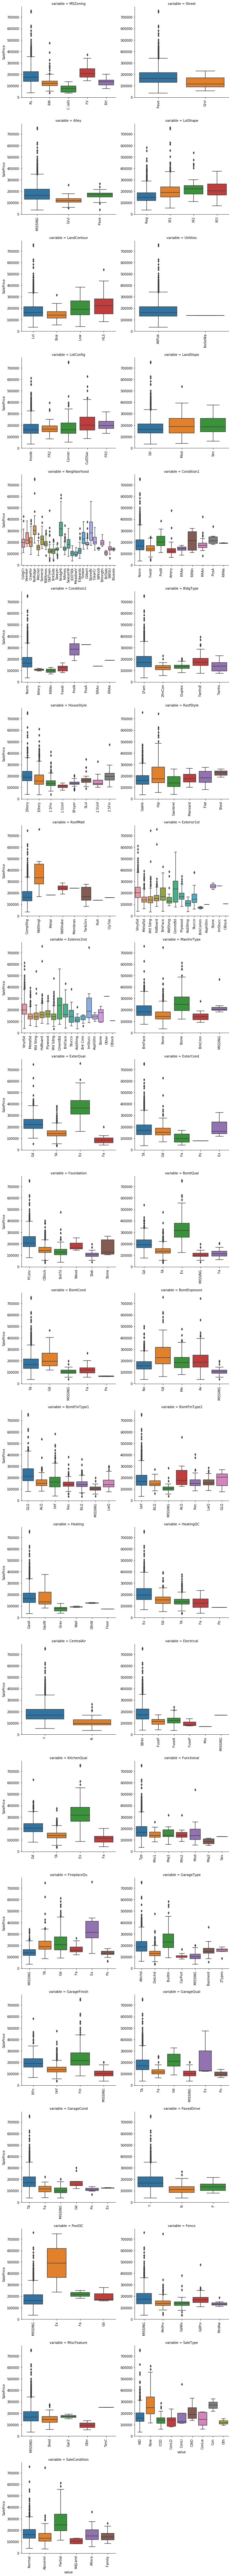

In [12]:
for c in qualitative : 
    train[c] = train[c].astype('category') #카테고리 자료형으로 만든다 .astype는 형변환
    if train[c].isnull().any(): #isnull().any()는 null이 하나라도 있는지 검사
        train[c] = train[c].cat.add_categories(['MISSING']) 
        train[c] = train[c].fillna('MISSING') # null이 있으면 MISSING을 넣어줌 

def boxplot(x,y,**kwargs):
    sns.boxplot(x=x,y=y)
    x=plt.xticks(rotation=90)
f = pd.melt(train,id_vars=['SalePrice'], value_vars=qualitative )
g = sns.FacetGrid(f, col="variable", col_wrap=2, sharex=False, sharey=False, size=5)
#주석달아주는것
g=g.map(boxplot, "value", "SalePrice")
        
        
        
        
#https://data-make.tistory.com/120